In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import time
from helper import *
from ALsim import ALsim
import sim
import sys
import os
from ALsimParameters import std_paras
import random

In [2]:

"""
experiment to investigate the effect of decreasing response with higher concentration. In this version we generate N_odour odours randomly with the following properties: 
1. Each odour has a a Gaussian profile of glomerulus activation with sigma drawn from Gauss(mu_sig,sig_sig). 
2. the Gaussian odour profile is over a random permutation of the glomeruli.
"""

ino= 0
connect_I= "hom"
o1= 5
o2= 99

paras= std_paras()

# write results into a dir with current date in the name
timestr = time.strftime("%Y-%m-%d")
paras["dirname"]= timestr+"-runs"

path = os.path.isdir(paras["dirname"])
if not path:
    print("making dir "+paras["dirname"])
    os.makedirs(paras["dirname"])

paras["use_spk_rec"]= True

paras["rec_state"]= [
    ("ORs", "ra"),
    ("ORNs", "V"),
#    ("ORNs", "a"),
    ("PNs", "V"),
    ("LNs", "V")
]

paras["rec_spikes"]= [
    "ORNs",
    "PNs",
    "LNs"
    ]


label= "run"
paras["label"]= label+"_"+str(ino)+"_"+str(o1)+"_"+str(o2)


# Load Hill coefficients and odors from file
hill_exp= np.load(paras["dirname"]+"/"+label+"_hill.npy")
odors= np.load(paras["dirname"]+"/"+label+"_odors.npy")
paras["N_odour"]= odors.shape[0]

correl= choose_inh_connectivity(paras,connect_I)                 

# Now, let's make a protocol where each odor is presented for 3 secs with
# 3 second breaks and at two representative concentration values
paras["protocol"]= []
t_off= 3000.0

for o in [o1, o2]:
    for c in [ 1e-6, 1e-1 ]:
        sub_prot= {
            "t": t_off,
            "odor": o,
            "ochn": "0",
            "concentration": c
        }
        paras["protocol"].append(sub_prot)        
        sub_prot= {
            "t": t_off+3000.0,
            "odor": o,
            "ochn": "0",
            "concentration": 0.0,
        }
        paras["protocol"].append(sub_prot)
        t_off+= 6000.0;

paras["t_total"]= t_off+3000.0
print("We are running for a total simulated time of {}ms".format(t_off))

if __name__ == "__main__":
    state_bufs, spike_t, spike_ID= ALsim(odors, hill_exp, paras, lns_gsyn= correl)


Homogeneous AL inhibition
We are running for a total simulated time of 27000.0ms
Set homogeneous LN -> PN inhibition matrix using initvar snippet
Set homogeneous LN -> LN inhibition matrix using initvar snippet
building model ...
200.0
400.0
600.0
800.0
1000.0
1200.0
1400.0
1600.0
1800.0
2000.0
fetched spikes from buffer ... complete
2200.0
2400.0
2600.0
2800.0
3000.0
3200.0
3400.0
3600.0
3800.0
4000.0
fetched spikes from buffer ... complete
4200.0
4200.2
4400.0
4400.2
4600.0
4600.2
4800.0
4800.2
5000.0
5200.0
5400.0
5600.0
5800.0
6000.0
fetched spikes from buffer ... complete
6200.0
6400.0
6600.0
6800.0
7000.0
7200.0
7400.0
7600.0
7800.0
8000.0
fetched spikes from buffer ... complete
8200.0
8400.0
8600.0
8800.0
9000.0
9200.0
9400.0
9600.0
9800.0
10000.0
fetched spikes from buffer ... complete
10200.0
10400.0
10600.0
10800.0
11000.0
11200.0
11400.0
11600.0
11800.0
12000.0
fetched spikes from buffer ... complete
12200.0
12400.0
12600.0
12800.0
13000.0
13200.0
13400.0
13600.0
13800.0
140

In [3]:
def plot_spikes(spike_t, spike_ID, idx, n, toff, ax):
    st= spike_t[spike_ID == idx*n]
    st= st[st >= toff]
    st= st[st <= toff+3500]
    st= np.reshape(st,(1,-1))
    x= np.vstack((st,st))
    y= np.ones(x.shape)
    y[0,:]= -70.0
    y[1,:]= 20.0
    ax.plot(x,y,'k',lw=0.8)

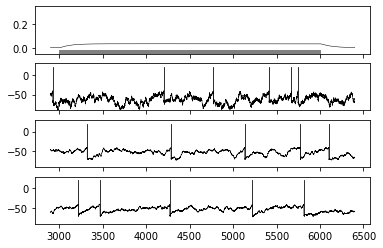

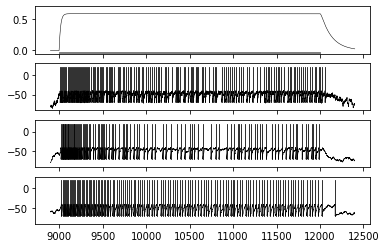

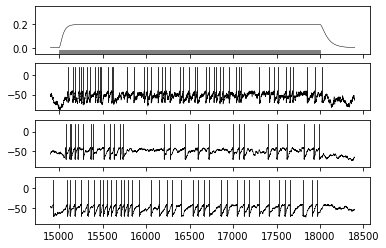

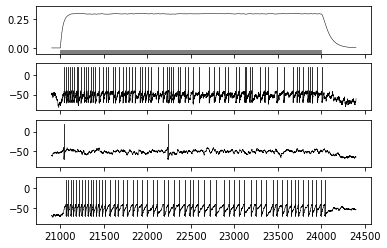

In [8]:
dt= paras["dt"]
for i in range(4):
    ioff= int((i*6000.0+2900.0)/dt)
    toff= ioff*dt
    # plot raw data of the responses - bound receptor, ORN V, PN V, LN V
    figure, ax= plt.subplots(4)
    t= np.arange(toff, toff+3500, dt)
    npts= t.shape[0]
    # find the strongest glomerulus
    ra= state_bufs["ORs_ra"][ioff:ioff+npts,:]
    ra_sum= np.sum(ra, axis=0)
    idx= np.argmax(ra_sum)
    ax[0].plot(t, ra[:,idx],'k',lw=0.5)
    ax[0].set_ylim([-0.05, np.maximum(0.35,1.2*np.amax(ra[:,idx]))])
    ax[0].set_xticklabels([])
    ax[0].add_patch(Rectangle((toff+100, -0.05), 3000, 0.03,
            edgecolor = 'grey',
            facecolor = 'grey',
            fill=True))
        
    VORN= state_bufs["ORNs_V"][ioff:ioff+npts,:]
    ax[1].plot(t, VORN[:,idx*paras["n"]["ORNs"]],'k',lw=0.5)
    plot_spikes(spike_t["ORNs"], spike_ID["ORNs"], idx, paras["n"]["ORNs"], toff, ax[1])
    ax[1].set_ylim([-90, 30])
    ax[1].set_xticklabels([])
    VPN= state_bufs["PNs_V"][ioff:ioff+npts,:]
    ax[2].plot(t, VPN[:,idx*paras["n"]["PNs"]],'k',lw=0.5)
    plot_spikes(spike_t["PNs"], spike_ID["PNs"], idx, paras["n"]["PNs"], toff, ax[2])
    ax[2].set_ylim([-90, 30])
    ax[2].set_xticklabels([])
    VLN= state_bufs["LNs_V"][ioff:ioff+npts,:]
    ax[3].plot(t, VLN[:,idx*paras["n"]["LNs"]],'k',lw=0.5)
    plot_spikes(spike_t["LNs"], spike_ID["LNs"], idx, paras["n"]["LNs"], toff, ax[3])
    ax[3].set_ylim([-90, 30])
    name= "ex_"+str(i)+"raw_traces.png"
    plt.savefig(name,dpi=300)
plt.show()
